# CS 51 Final Project Interface

By: Olivia Angiuli, Martin Reindl, Ty Rocca, Wilder Wohns

**Purpose:** This top level iPython notebook is designed to be a place to see how our code works. It is also a good way for us to show off our results

In [3]:
#!/usr/bin/env python

In [7]:

###############################################################################
#                                   Main                                      #
###############################################################################
# Main lies at the center of our clustering. It combines several              #
# other modules (see below) to check user input and then follow the four step #
# implementation of clustering we outlined in our proposal:                   #
# 1) Load Data                                                                #
# 2) Initialize Clusters                                                      #
# 3) Run Classification Algorithm                                             #
# 4) Find Accuracy                                                            #
###############################################################################

###############################################################################
#                               Import Packages                               #
###############################################################################
# import numpy and abbreviate because of common use
import numpy as np
# import other helper modules
import os, struct, random, sys, base64, json, timeit
# Import our modules
import Initialize, Accuracy, Distance, File, Kmeans, ClassifyClusters

###############################################################################
#                                 Load Data                                   #
###############################################################################

# set proportion of data (full set will take a while), prop takes proportion 
prop = 5

# load training and testing images and labels as 60,000 x 28 x 28 array
train_images,train_labels=File.load_mnist("training",path=os.getcwd(),prop=prop)
test_images,test_labels = File.load_mnist("testing",path=os.getcwd())

# flatten training images into 60,000 x 784 array
train_images_flat = np.array([np.ravel(img) for img in train_images])
test_images_flat = np.array([np.ravel(img) for img in test_images])


###############################################################################
#                       Run Classification Algorithm                          #
###############################################################################
"""
    Runs the classification algorithm with conditions supplied

    Inputs 
    -------
    k : the number of clusters

    m : the type of clustering (either 'means', 'medians', or 'medoids')

    init_type : type of initialization (either 'random' or 'kmeans_plusplus')

    Outputs
    -------
    Prints time values, as well as major steps of the algorithm for user to 
    follow along. 
"""
def main (k, m="means", init_type="random"):
    
    # show user what s/he is running
    print "Running %s algorithm with %s initialization, %d percent of the dataset\
    , and %d clusters" % (m, init_type, prop, k)
    
    # Starting clustering timer
    start_cluster = timeit.default_timer()

    # Initialize clusters
    if init_type == "random":
        initial_clusters = Initialize.random_centers(k)
    else:
        init_type = "kplusplus"
        initial_clusters = Initialize.kmeans_plusplus(k, train_images_flat,\
            dist_fn=Distance.sumsq)
        
    # Run clustering algorithm
    final_responsibilities, final_clusters = Kmeans.kmeans(k,train_images_flat,
        initial_clusters, distfn = Distance.sumsq, method=m)

    # Find and print clustering time
    end_cluster = timeit.default_timer()
    clustering_time = end_cluster - start_cluster
    print "Time spent clustering : ", clustering_time

    # Save representative images to file.
    title = m + "_" + init_type + "_cluster" + str(k)
    File.save_images(k, train_images, final_responsibilities, 
                     final_clusters, title)

    ###########################################################################
    #                           Calculate Accuracy                            #
    ###########################################################################

    # Calculate final accuracy for clusters
    final, cluster_set = Accuracy.final_accuracy(final_responsibilities, 
        train_labels, train_images_flat, final_clusters)

    # Now see how well we can classify the dataset
    start_cluster_test = timeit.default_timer()
    predictions = ClassifyClusters.classify(cluster_set, test_images_flat, 
        test_labels, distfn = Distance.sumsq)
    finish_cluster_test = timeit.default_timer()

    # find time it took to test 
    testing_time = finish_cluster_test - start_cluster_test
    print "Time spent testing : ", testing_time

    ###########################################################################
    #                                 Outputs                                 #
    ###########################################################################

    # k, prediction level, cluster_set, 
    results = {"k" : k, "prediction_accuracy" : predictions[1], 
    "cluster_means" : cluster_set, "cluster_stats" : final,
    "clustering_time" : clustering_time, "testing_time" : testing_time}

    with open('./results/' + title + '/' + title + '_results.json', 'w') as outfile:
        json.dump(results, outfile, cls=File.NumpyEncoder)

In [8]:
###############################################################################
#                               Call to Function                              #
###############################################################################

# This is an example call if you want to run it in the ipython notebook. This is 
# only on 5% of the data because it takes a long time to run
main(10, m="medians", init_type="k_plus_plus")

Running medians algorithm with k_plus_plus initialization, 5 percent of the dataset    , and 10 clusters
0 [ 247.  168.  245.  206.  502.  274.  450.  472.  120.  316.]
1 [ 259.  149.  283.  229.  444.  236.  495.  464.  123.  318.]
2 [ 278.  149.  327.  248.  381.  220.  492.  449.  127.  329.]
3 [ 299.  150.  358.  264.  350.  218.  428.  469.  129.  335.]
4 [ 309.  149.  380.  276.  327.  212.  361.  522.  130.  334.]
5 [ 329.  149.  385.  295.  310.  192.  324.  564.  130.  322.]
6 [ 342.  151.  383.  314.  292.  182.  319.  576.  127.  314.]
7 [ 352.  149.  401.  331.  291.  188.  327.  524.  126.  311.]
8 [ 352.  149.  420.  342.  293.  193.  342.  468.  126.  315.]
9 [ 349.  149.  436.  348.  292.  200.  356.  420.  127.  323.]
10 [ 345.  150.  441.  354.  289.  208.  368.  386.  127.  332.]
11 [ 344.  150.  457.  365.  289.  211.  377.  347.  128.  332.]
12 [ 349.  151.  467.  376.  282.  211.  383.  319.  127.  335.]
13 [ 346.  150.  470.  388.  280.  213.  384.  309.  128.  3

In [4]:
# How to load the data back in from files, since data loading is tricky:
# json.loads(dumped, object_hook=json_numpy_obj_hook)

# source : http://stackoverflow.com/questions/3488934/simplejson-and-numpy-array/24375113#24375113
import base64
import json
import numpy as np

def json_numpy_obj_hook(dct):
        """
        Decodes a previously encoded numpy ndarray
        with proper shape and dtype
        :param dct: (dict) json encoded ndarray
        :return: (ndarray) if input was an encoded ndarray
        """
        if isinstance(dct, dict) and '__ndarray__' in dct:
            data = base64.b64decode(dct['__ndarray__'])
            return np.frombuffer(data, dct['dtype']).reshape(dct['shape'])
        return dct


In [11]:
# All of the options we tested:

testing_ks = range(10,20) + range(20, 55, 5)
methods = ["means", "medoids", "medians"]
init_types = ["random", "kplusplus"]

# Results appended to df
results_set = []
for k in testing_ks:
    for m in methods:
        for init_type in init_types:
            title = m + "_" + init_type + "_cluster" + str(k)
            # Load in the file
            with open('./results/' + title + '/' + title + '_results.json') as data_file:
                json_in = json.load(data_file,object_hook=json_numpy_obj_hook)
                json_in["method"] = m
                json_in["init_type"] = init_type
                json_in["title"] = title
                results_set.append(json_in)
import pandas as pd
results_df = pd.DataFrame(results_set)

In [12]:
# Reorder
results_df = results_df[[u'method', u'init_type', u'k', 
                         u'prediction_accuracy', u'clustering_time', 
                         u'testing_time', u'cluster_means', 
                        u'cluster_stats', u"title"]]


In [13]:
# Here is the head of the output of our code
results_df.head()

,method,init_type,k,prediction_accuracy,clustering_time,testing_time,cluster_means,cluster_stats,title
0,means,random,10,59.465947,6564.869596,22.154983,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.858911697621, 1694.73068149, 6138.0],...",means_random_cluster10
1,means,kplusplus,10,59.575958,6359.469025,27.613850,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.944126402565, 1745.659018, 4367.0], [...",means_kplusplus_cluster10
2,medoids,random,10,44.614461,374.554019,25.656851,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.812128662159, 2168.16810076, 4881.0],...",medoids_random_cluster10
3,medoids,kplusplus,10,48.364836,1159.850245,65.437160,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.662012578616, 2106.44993705, 7950.0],...",medoids_kplusplus_cluster10
4,medians,random,10,55.965597,8419.787714,24.625500,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.907110318875, 2011.71413908, 5049.0],...",medians_random_cluster10


In [27]:
# Now we plot our dataset
# Here is the function to make plots

%matplotlib inline
import matplotlib.pyplot as plt

def plotset (xdata, ydata, title, labels=[False]):
    
    ## I
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(xdata, ydata, marker = 'o', c ="blue", s = 100)
    if labels[0]:
        labels = labels[1]
        for label, x, y in zip(labels, xdata, ydata):
            plt.annotate(
                label, 
                xy = (x, y), xytext = (-20, 20),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    plt.suptitle(title)
    title = title.split(" vs. ")
    plt.ylabel(title[0])
    plt.xlabel(title[1].split(" for")[0])
    
    plt.show()

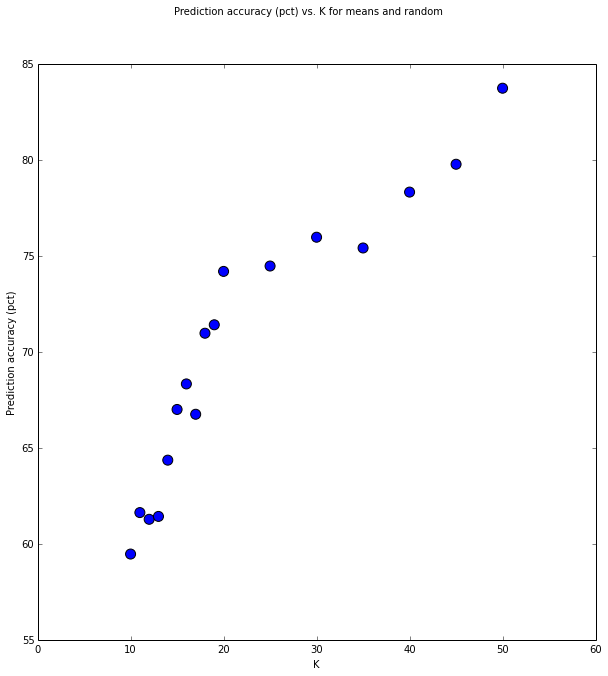

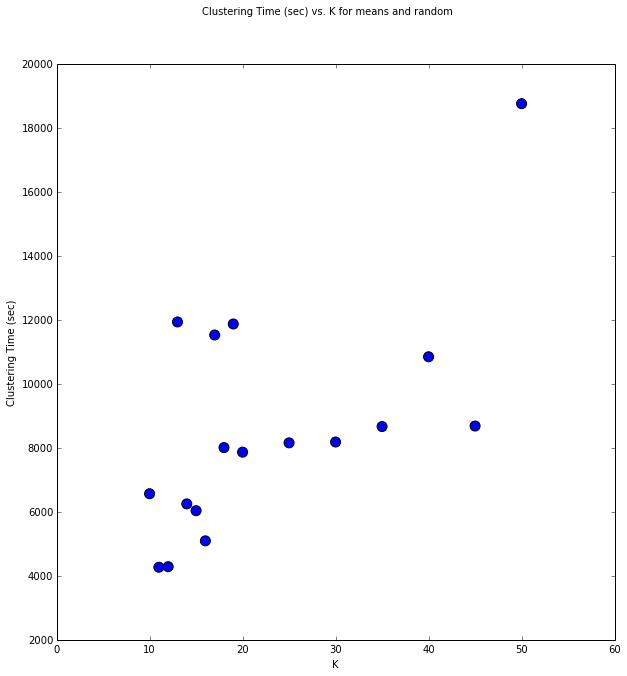

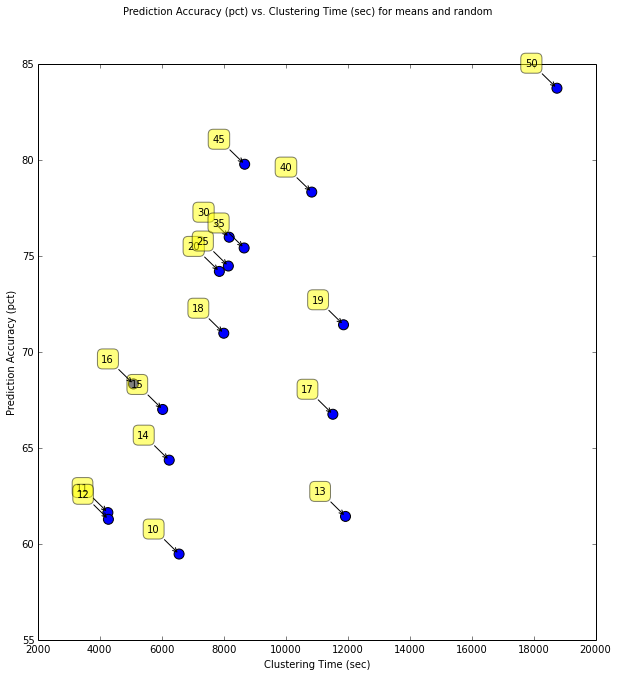

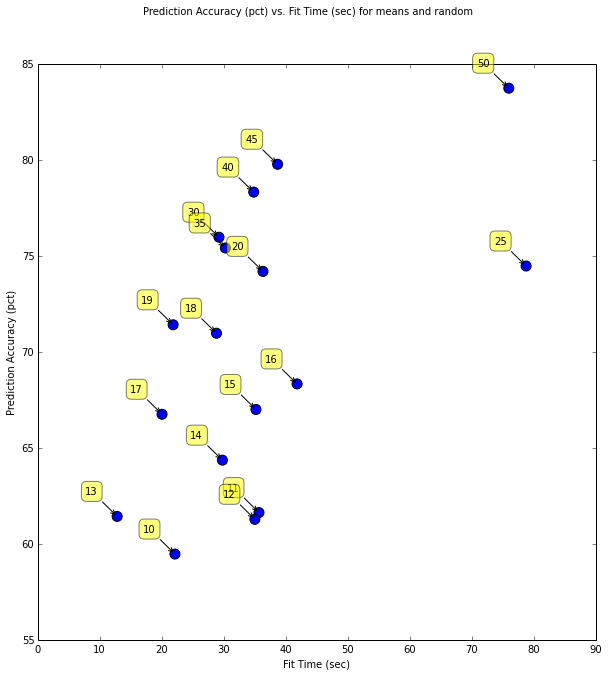

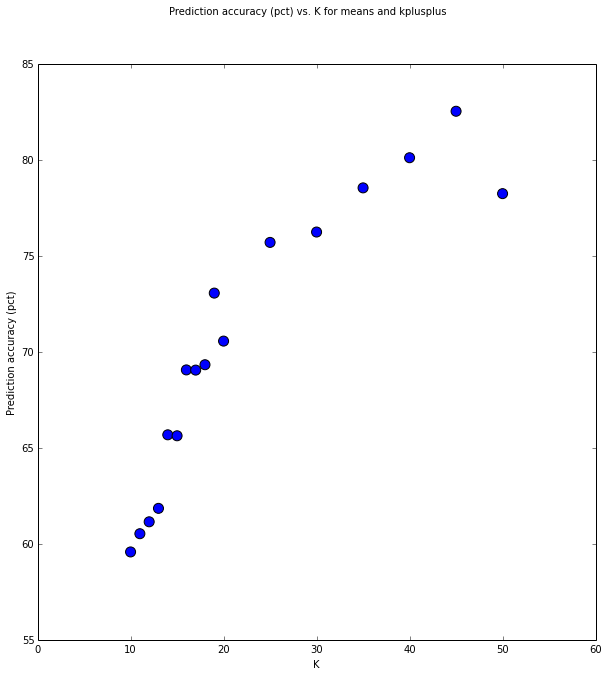

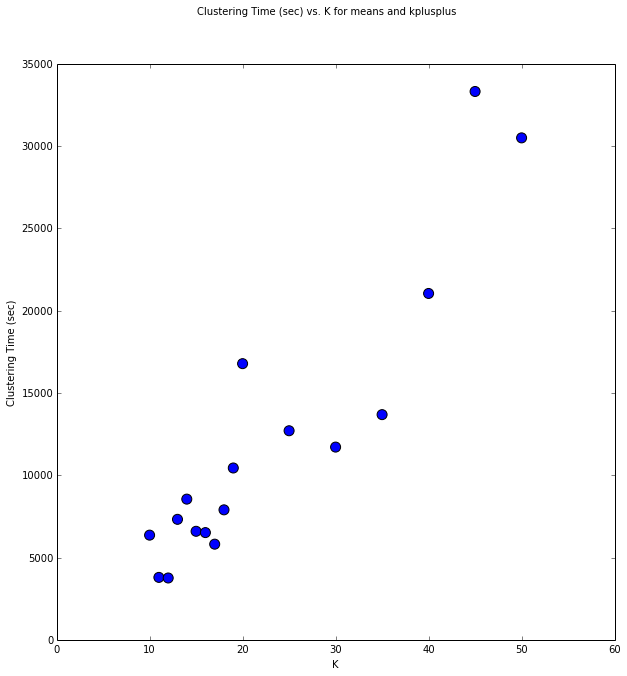

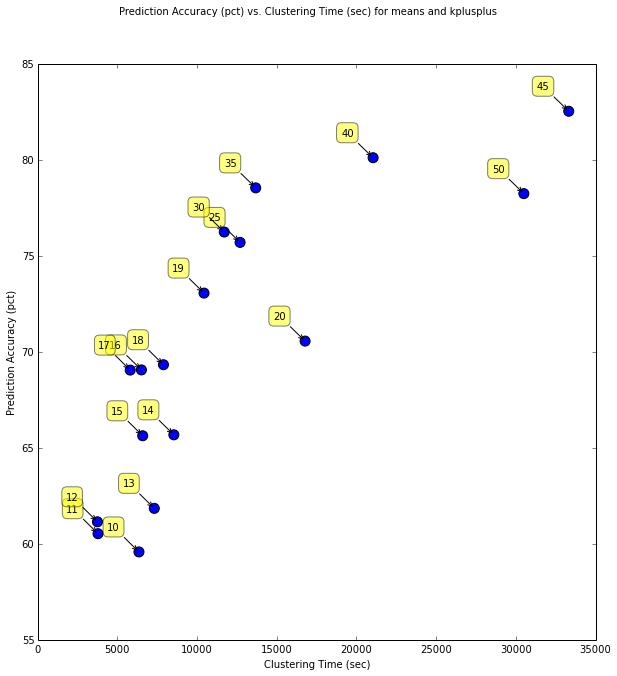

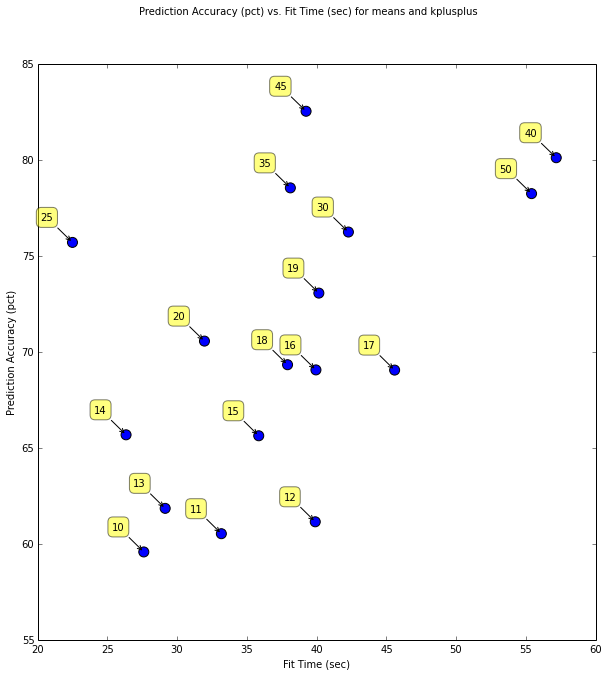

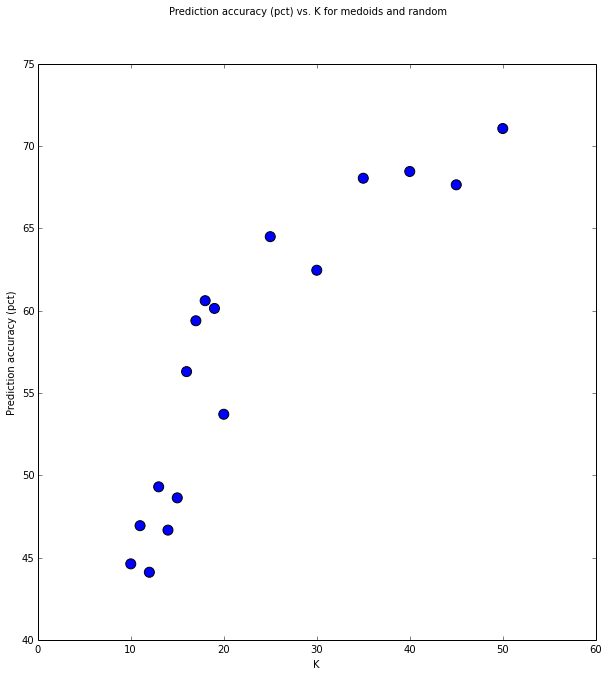

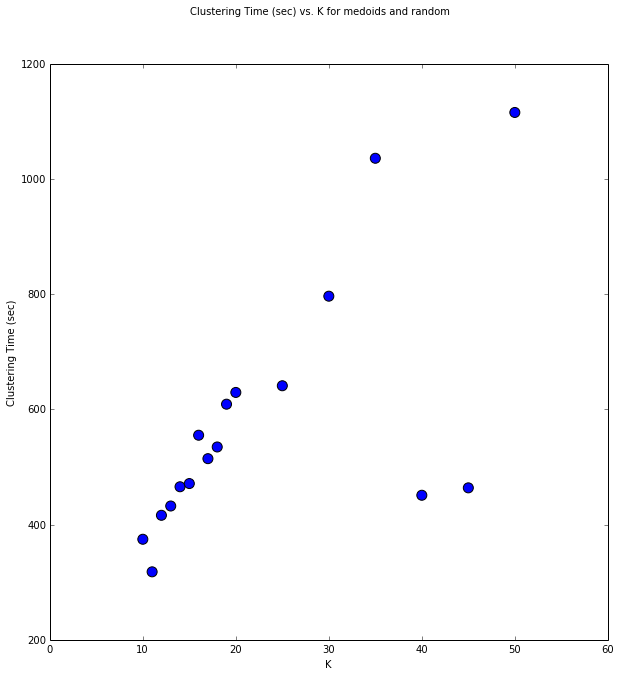

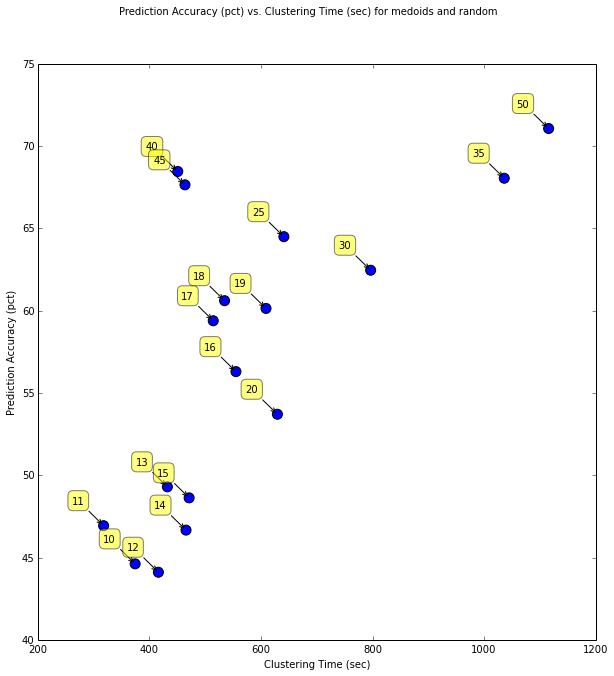

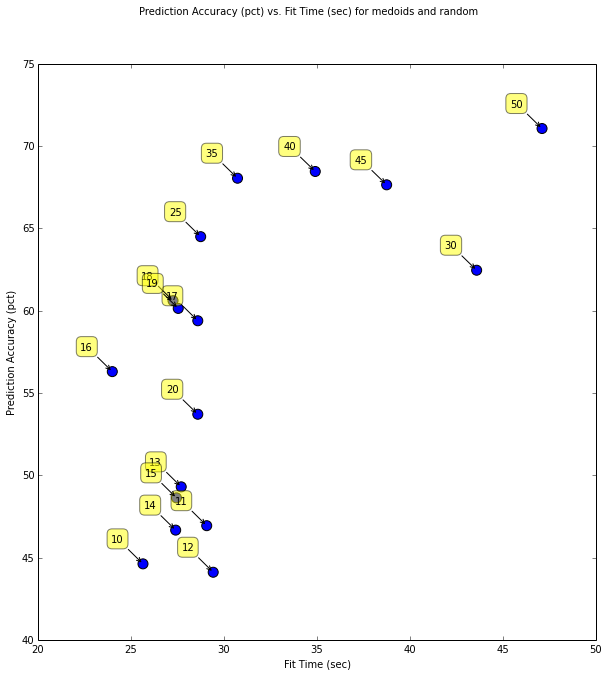

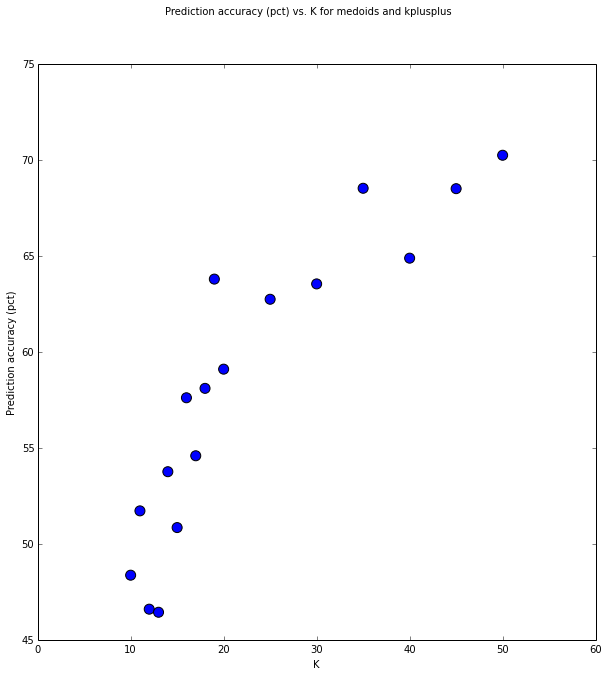

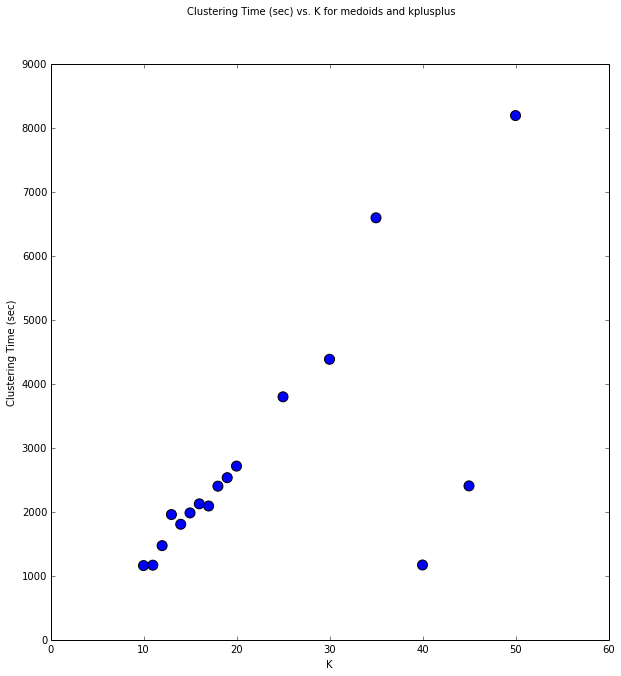

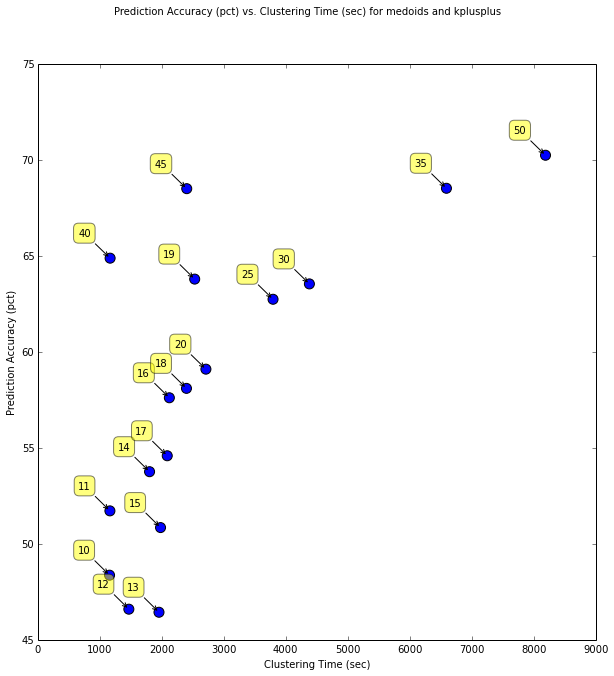

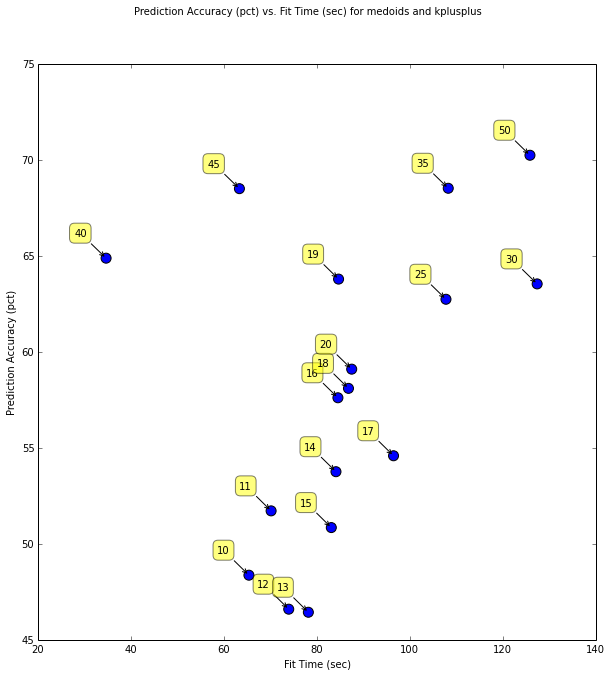

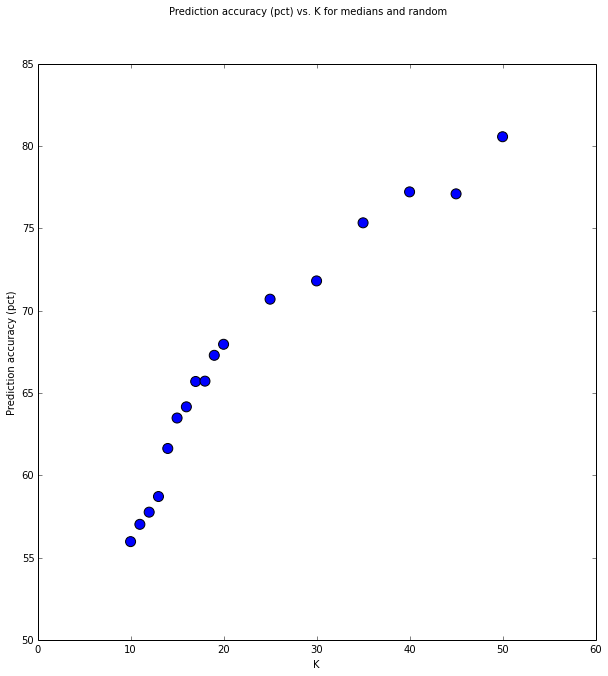

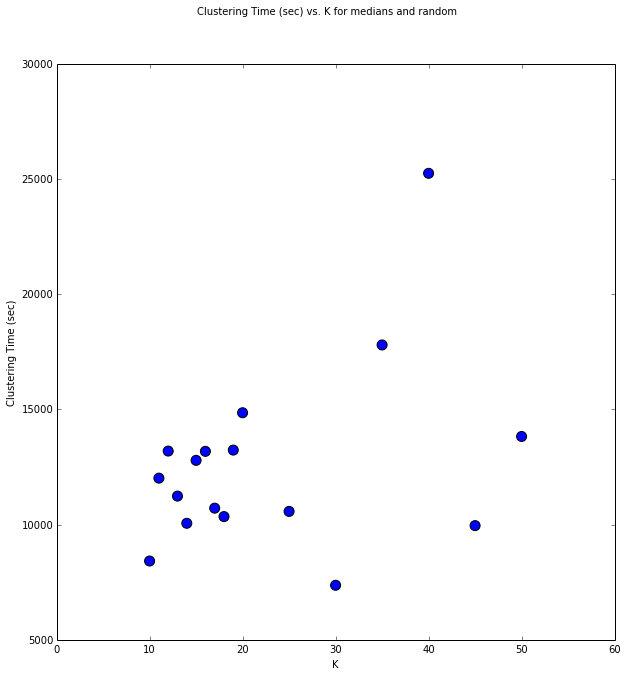

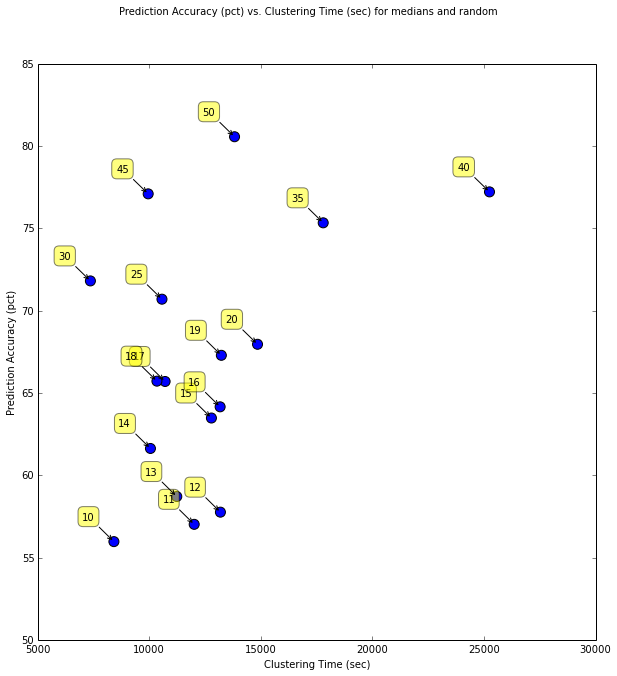

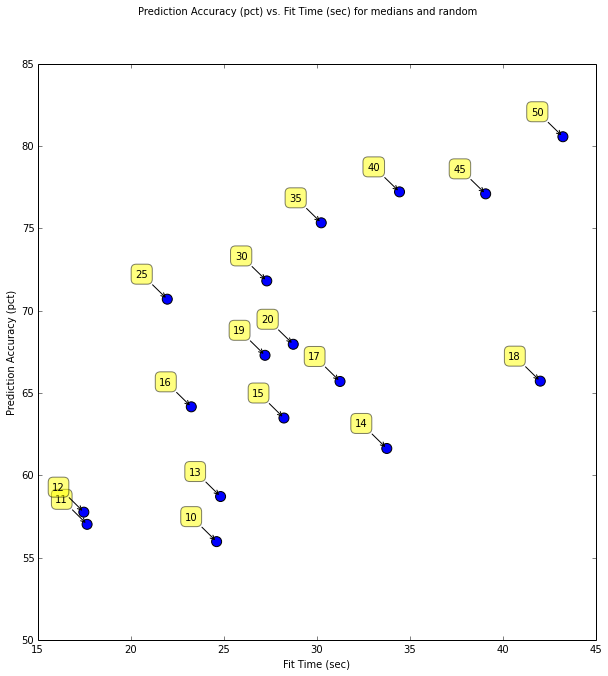

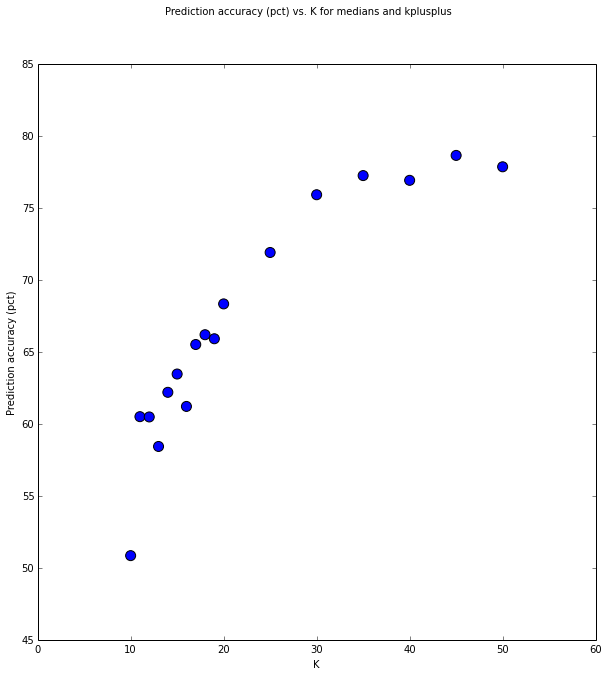

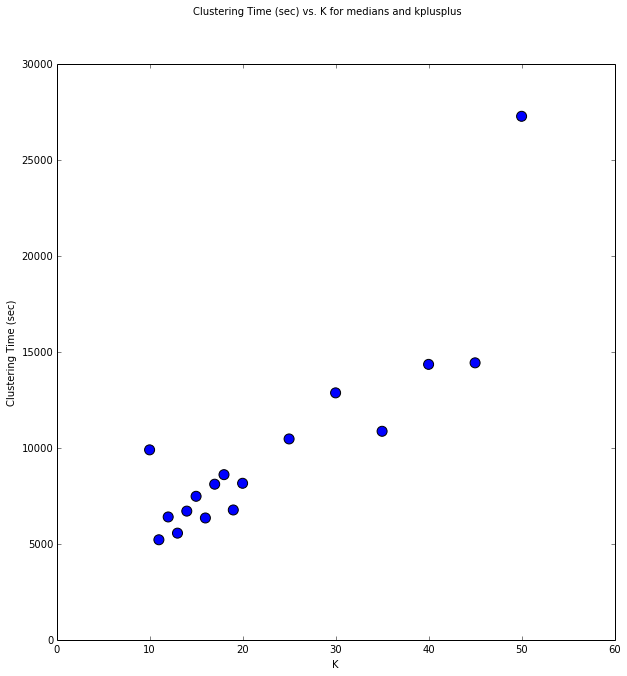

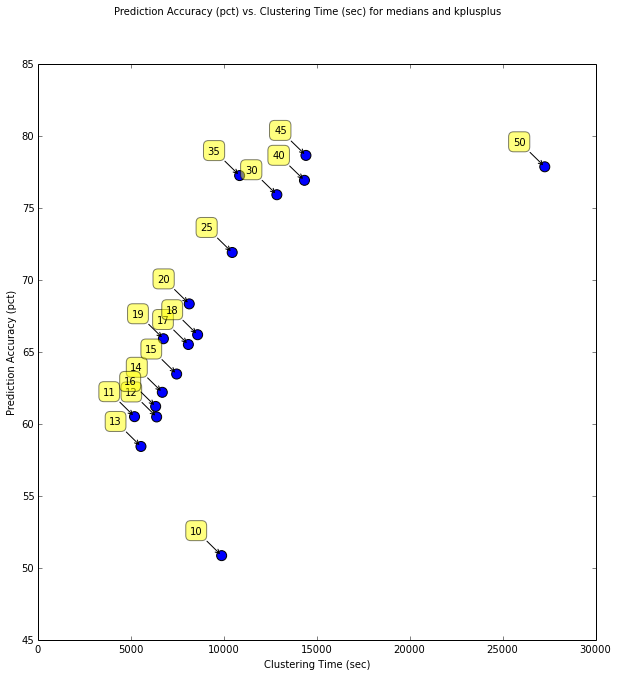

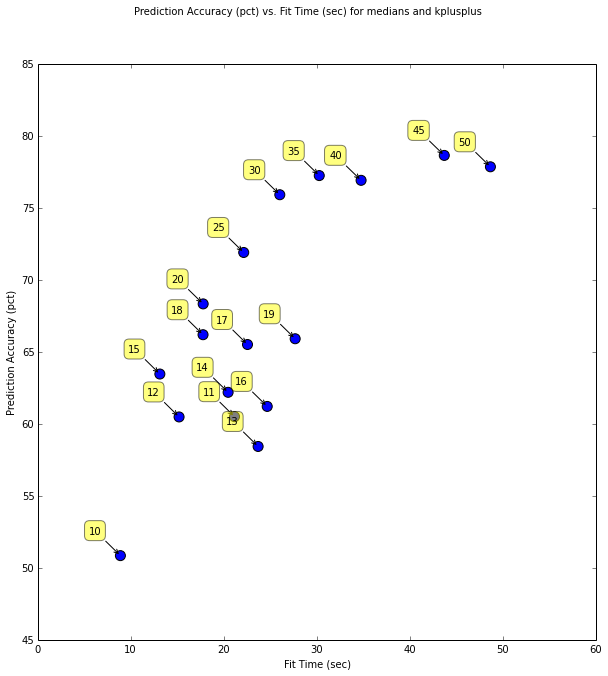

In [28]:
# For each method - initialization type we gernerate the following graphs:
#   1.) Prediction accuracy vs. K
#   2.) Clustering Time vs. K
#   3.) Prediction Accuracy vs. Clustering Time
#   4.) Prediction Accuracy vs. Fit Time

for m in methods:
    for init_t in init_types:
        df = results_df[(results_df.method==m) & (results_df.init_type==init_t)]
        plotset(df.k, df.prediction_accuracy, ("Prediction accuracy (pct) vs. K for %s and %s"%(m, init_t)))
        plotset(df.k, df.clustering_time, ("Clustering Time (sec) vs. K for %s and %s"%(m, init_t)))
        plotset(df.clustering_time, df.prediction_accuracy, 
                ("Prediction Accuracy (pct) vs. Clustering Time (sec) for %s and %s"%(m, init_t)), [True, df.k])
        plotset(df.testing_time, df.prediction_accuracy, 
                ("Prediction Accuracy (pct) vs. Fit Time (sec) for %s and %s"%(m, init_t)), [True, df.k])
        

**Observations:** The results above had some interesting results. As expected, accuracy generally increases with more clusters, however, this comes with the cost of more time spent clustering. To determine the "best" we used the "elbow method". This means that we looked for the place where it looked like the tradeoff in accuracy was not worth the added time. WE also noticved that the times to classify were almost the same for all values of k. This shows that it might be worth having more clusters becasue once you make the clusters, it's not that hard to classify the outputs 

In [34]:
# Here we look at just the absolute best results for each method and initialization type. 
# Surprisingly we found that random initialization was best.
for m in methods:
    for init_t in init_types:
        df = results_df[(results_df.method==m) & (results_df.init_type==init_t)]
        print "The best Accuracy was: ", df.prediction_accuracy.max(), " in %s and %s"%(m, init_t)
        df = df[df.prediction_accuracy == df.prediction_accuracy.max()]
        print "And the K value was: ", df.k.max(), ", while runtime was ", df.clustering_time.max()
        print ""
        
   
### overall best results
print "The best Accuracy was ", results_df.prediction_accuracy.max()
df = results_df[results_df.prediction_accuracy == results_df.prediction_accuracy.max()]
print "The method was %s, and the initialization type was %s" %(str(df.method.max()), str(df.init_type.max()))
print "And the K value was: %d" %(int(df.k.max())), " while runtime was ", df.clustering_time.max()


The best Accuracy was:  83.7283728373  in means and random
And the K value was:  50 , while runtime was  18753.93137

The best Accuracy was:  82.5282528253  in means and kplusplus
And the K value was:  45 , while runtime was  33317.708555

The best Accuracy was:  71.0671067107  in medoids and random
And the K value was:  50 , while runtime was  1115.51690888

The best Accuracy was:  70.2370237024  in medoids and kplusplus
And the K value was:  50 , while runtime was  8191.43628502

The best Accuracy was:  80.5680568057  in medians and random
And the K value was:  50 , while runtime was  13824.5823519

The best Accuracy was:  78.6378637864  in medians and kplusplus
And the K value was:  45 , while runtime was  14425.0948539

The best Accuracy was  83.7283728373
The method was means, and the initialization type was random
And the K value was: 50  while runtime was  18753.93137


In [36]:
# When we chose the elbows we had to look for their values, here is a function we wrote to pinpoint them

In [41]:
def get_vals2(m, init_t, k, df=results_df):
    df = df[(df.method==m) & (df.init_type==init_t) & (df.k==k)]
    print "The best Elbow Accuracy was: ", df.prediction_accuracy.max(), " in %s and %s"%(m, init_t)
    df = df[df.prediction_accuracy == df.prediction_accuracy.max()]
    print "And the Elbow K value was: ", df.k.max(), ", while runtime was ", df.clustering_time.max()
    print ""

# Our eyeballed "ELbpws
get_vals2("means", "kplusplus", 35)
get_vals2("means", "random", 40)
get_vals2("medoids", "random", 40)
get_vals2("medoids", "kplusplus", 45)
get_vals2("medians", "random", 45)
get_vals2("medians", "kplusplus", 35)

The best Elbow Accuracy was:  78.5378537854  in means and kplusplus
And the Elbow K value was:  35 , while runtime was  13682.2087078

The best Elbow Accuracy was:  78.3178317832  in means and random
And the Elbow K value was:  40 , while runtime was  10844.4729168

The best Elbow Accuracy was:  68.4568456846  in medoids and random
And the Elbow K value was:  40 , while runtime was  450.943001986

The best Elbow Accuracy was:  68.496849685  in medoids and kplusplus
And the Elbow K value was:  45 , while runtime was  2404.88158703

The best Elbow Accuracy was:  77.097709771  in medians and random
And the Elbow K value was:  45 , while runtime was  9955.3224709

The best Elbow Accuracy was:  77.2377237724  in medians and kplusplus
And the Elbow K value was:  35 , while runtime was  10859.8179948



Overall, we thought the  means and kplusplus was the best one, since it did not take horribly long, bus was still accurate

### Extras

Below we have some extra things that might be useful. the below code outputs strings of nohup commands to 
output the results of nohuping the clusters

In [45]:
# Paste this output in an AWS server to save you time when running all the clusters
for method in methods:
    for init_type in init_types:
        for k in testing_ks:
            print "nohup python main_cluster.py {k} {method} {init_type} {prop} > {method}_{init_type}_cluster{k}.out &".format(k = k,
                                                                                method = m,
                                                                                init_type =init_type,
                                                                                prop = 100)
            
# Example output: nohup python main_cluster.py 10 medians random 100 > medians_random_cluster10.out &

#### Below is stuff we used to make the front end of our application:

In [5]:
# Example stuff for image processing in frontend

title = "means_random_cluster50"
# Load in the file of the best clusters
with open('./results/' + title + '/' + title + '_results.json') as data_file:
    json_in = json.load(data_file,object_hook=json_numpy_obj_hook)
best_set = json_in

In [466]:
#algorithm for identifying the drawn images

import numpy as np

import Distance
def classify(cluster_set,test_set,distfn=Distance.sumsq):
    
    # Clusters is the array of final cluster means
    clusters = []
    c_index = []
    for cluster in cluster_set:
        clusters.append(cluster[0])
        c_index.append(cluster[1])

    test_clusters_asgn = np.apply_along_axis(Distance.leastsquares, 1, 
        test_set, clusters[1:49], distfn)

    test_clusters = np.array([c_index[i+1] for i in test_clusters_asgn])

    return int(test_clusters[0])

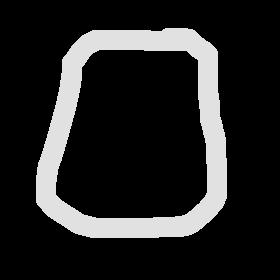

In [376]:
# Example Image read in (from the database):
image_string = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARgAAAEYCAYAAACHjumMAAAYGklEQVR4Xu2df+yvZVnH3xdQQtmCggED4Zg2KilQS13aELSBmwasPyRoKmHNciWwWZjFD9eGlRNzLedCftQCaS2O4h8wiwMGW9gPICBpg0CBSRPssJmicLzb/eE5xy+H7znPj891P8/94/Vs569z39d936/r+ry/93P/uB4TDwQgAIFEBCyRXcxCAAIQEAJDEEAAAskIIDDJ0GIYAhBAYIgBCEAgGQEEJhlaDEMAAggMMQABCCQjgMAkQ4thCEAAgSEGIACBZAQQmGRoMQwBCCAwxAAEIJCMAAKTDC2GIQABBIYYgAAEkhFAYJKhxTAEIIDAEAMQgEAyAghMMrQYhgAEEBhiAAIQSEYAgUmGFsMQgAACQwxAAALJCCAwydBiGAIQQGCIAQhAIBkBBCYZWgxDAAIIDDEAAQgkI4DAJEOLYQhAAIEhBiAAgWQEEJhkaDEMAQggMMQABCCQjAACkwwthiEAAQSGGMiOQAg6TdLbJZ0k6RBprS+Q7pB0j6QvSLrITNuzG3DFHUJgKnZuaUMLQcdL+rSkY2bo+9OSHpB0g5l+f4b2mmwCgZnZ7SHoUmn1F/pISS+euflUzcUf6+PdTOHfJN0i6Skz3TW0wRB0cZxhDC3vXO7bkt5ppuuc7TZvDoGZKQRC0IWSPijp+2dqkmbGE7jFTCeOr0aNPRFAYBLHRgh6o6RrJR2WuCnM+xDYaqbTfUxhBYFJFAMhaIukK6WVwPCUReAcM11RVpfz7C0C4+yXEHSgpMskvcvZNObmJXC+2cqPPGsQQGDWgLexaicsn+gWcPd3MouZZQnwurQmfwRmTYCxegirMxt/xQKuA8z8TNxmpl/Ir1tl9AiBWdNPIWirpFPXNEP1vAncaaZX5d3FPHuHwKzhlxD0n5J+cg0TVC2HQDyU93OcBB7nMARmHK9dpUPQjZJOnlidamUSeFLSm8ccICxzmH69RmAmsAxBV8WTnxOqUqV8At+VdIWZfr38oaQfAQIzkjHiMhJYvcXvl/QrzGb27mAEZsQPIATdLHGUfASyForeIOkdrM1s7moEZuBPIATdJun1A4tTrC0CMSXEe8x0eVvD7h8tAtPPKJ5zYSt6ACeKiIN5uwUBAtPzqwhB50n6KD8eCAwkcK+Zfnpg2eqLITB7cXF3/P8JSftWHwkM0JPAI2Y6ytNgqbYQmL0LzB2SXlOqc+n3ogQeM1slFWv6QWD24P4uL+z1TUcHg1+XwDazVV7hZh8EZhPXd69GD0mr1As8EFiHwBktp+JEYDYXmLl3ja6WdG6JZym6RN1RiGNirVdLqwXOQyXlkLIi5gp+UNLnJf2qpIPXUYqJdZ8xazdNKgKzW9TM/Gp0a0xMZaaHJwYv1UYQCEH/0QngiFouRT9spg+4WCrMCAKzwWHdq9FXZ/jr+3VJv2y2yr7PMyOBhQ5M3memY2ccZjZNITDPF5ivSHpJYu/cbqY3JG4D83shsMDByWZfkxCYLhBD0Bdjvo/Ev8yrzcjVm5jxIPPdZ2Tid5j2GVRhzUJma32dcs3Wl6uOwDyX8jJ+IOy4xG5AXBIDHmu+W6D+R0k/Mrbu2PIIzFhilZQPYbUOckLi4TR/HiIx38nmu3W3z6W+yIrATHZRuRW7ZN3xW8gpH46Np6TrZDsEnSvpTyXt52TyeWYQmBRUM7cZgr4p6YCE3YznMA4v8XxLQibZmu5mM38r6Re9O4nAeBPN3F73EfoLEnfzdLNVqgeeggh0azN3enYZgfGkWYCtGdZePmOm0wpAQRc3IRCCgicYBMaTZgG2QtD/Jrxr9JSkLbwaFRAIe+giAuPju2a3qUNQzA6favy8GvnE52JWEBgf9Kl+YD69S2jFO4A2dPWLZnptwq5jegYC3vHBK9IMTsupCe8A6sYWkz8fzKtRTp6e1hfv+EBgpvmh2FreAdSBON9MlxULhY7vIuAdHwhMY8HlHUCSrjXTmY1hrHa43vGBwFQbKpsPjABqzOEjh0t8jAS2h+Is8vpwVKt/oZzwZWcGgfFxCQLjwxGBceKYixkExscTCIwPRwTGiWMuZhAYH08gMD4cERgnjrmYQWB8PIHA+HBEYJw45mIGgfHxRJMCk+C27A6zNHlEfNyMlbEEEJixxDYv36rAxG/4bPNBuLLytFnSvDKOXcXUEAIIzBBK/WVaFZiYvczzxO2XzbSlHzclSiGAwPh4qlWBuVhSzCjv9ZBz14tkJnYQGB9HtCow3om+LzFTFC2eSgggMD6ORGB8OJL/xYdjNlYQGB9XtCowrukQJZ3IZ2B9AjIXKwiMjyeaE5guc3xMl+n5HEQOGE+cy9tCYHx80KLAeG9Rc8jOJxazsoLA+LijRYGJmf6v98G3snKrmaJo8VREAIHxcWaLAuO9RY3A+MRiVlYQGB93tCgwn5X0Nh98KytsUTvCzMUUAuPjiRYF5nFJh/rgW1k5z0wfc7SHqQwIIDA+TmhRYGLm/3188K2ssEXtCDMXUwiMjyeaEpgQVveFHvJBt8vKK810l7NNzC1MAIHxcUBrAvMuSVf6oHvOCrl4PWnmYwuB8fFFawIT10re54NuZYU0DY4wczKFwPh4ozWBuVPS8T7oVlb+20wvc7SHqUwIIDA+jmhNYLzvIH3STO/xcQVWciKAwPh4oxmBCWF12tYzi130ADtIPnGYnRUExsclLQmM9wleFnh9YjBLKyHoWUn7Onauyd3GlgRmq6RTHQPmbjPX9RzHrmFqXQIh6FuS9l/Xzob6Tc52WxKYmKLhQMeA+TMzxdy+PBUSCEEPSzracWhNXilpQmASHbA720xXOQYgpjIiEIJujmtsjl26xkxnOdorwlQrAuN+wE7SS81Wf+V4KiQQwirHsmdi+Ca/PNGKwHgfsHvKzPV1q8KfaNlDCkHeeYO+Y6YXlU1lfO9bERjvA3afMVsFIE+lBFIca2jxWkkrAuN9wK7JBbtKtWSPw/I+C9Pia3X1ApPiLxEH7NqQmhBEao81Xd2CwMSdnneuyel51Vuc6nryK8VWCHpU0hGO/W3u+1ktCMxXJR3mGCQcsHOEmbOpEPSvkl7t2MfmXq1bEJhnJO3nGCQcsHOEmbOpBFvVCEzODh/btxBWR/njDpLnwwE7T5oZ20ogMPeZ6diMh+zetapnMAkCJDqAA3buYZinwQRnYZo7bFe7wNwi6QTH8H3WTN/naA9TGRNIsAPZXPzULjDe518eMdNRGf8m6JojgQR32IKZ6xctHEebxlS1ApNgehs98BEzvT+NK7CaIwHvw3atHXGoWWC87x+x/pKjAiTuEwKzHuCaBcb7/tH/mLmep1nPc9SehQACsx7mKgUmhNVN55hgyvO52kwx7QNPQwQQmPWcXavApMj/wvmX9WKtyNoIzHpuq1Vg3O8fSTrITNvXw03t0gggMOt5rFaB4f7RenFB7Y4AArNeKFQnMAnOLkTC3D9aL86KrY3ArOe6GgXmzyW9dz0sL6jd3DV7Z37FmvMWmNaumtQoMN6vR3xgrVh5WL/jCQTmc2Z62/o9K8NCjQLjnZ7hVrPVZ2d5GiSQQGB2mLmmD8naK1UJTILLadF5zeXwyDpiZ+5cgi88xhGcb6bLZh7KIs3VJjDe37KJTmnym8KLRGOGjYageyW9wrlrd5jpdc42szRXm8B4Xw9o7np9llG6YKdC0KWSLnDuwtNmOsDZZpbmqhGYRNcDHjfT4Vl6jk7NRiDB1wWa2TioSWBSXA/4YzP3v16z/TBoyIdACPobSWf6WNtl5UQzxYRoVT81CUyK6wGkx6w6/IcNLtHhzSbuttUkMA9J2jIsZAaVIj3DIExtFAphdTs/3tL3epq4nV+FwCT6egDXA7x+ShXYCUFbJZ3qOJQnzHSIo70sTdUiMOdK7ucKuB6QZcgu06kQVrmArnRsvYkdyloExvvrAc2s8jv+YKo2legQZ/ULvbUIjPfXA7geULVcTBtcgmsD1b+GFy8wib4ecJ6ZYtJwHgjsIpDg2sBDZvqxmhHXIDApvh7A9YCao37i2ELQg5K7IFR9FKIGgfFOz9Dc5z0n/t6aqxaCLoyXX50HfpGZPuRsMxtzRQtMogNQTZxPyCYCC+pIonj7kpl+qiAMo7pausB8WNLvjRpxf+EmTlj2Y6DEZgRCkPeBzqovPpYuMN6vRzGm+HoA2rJHAiGsFv/f54mo5s/Jli4w3tnr7jbT8Z7Bg626CHAeZpw/ixWYRNvTZK8bFz9Nlg5B3n/Yqn0tL1lg3Keqkqo/WdmkIjgPOgR9TdLBjmavM9MZjvayMVWywHgvtjVxNySbyCu4IyHIOzVItUcjihSYRNuFj5jpqILjnq7PRCDBxcftZjpopu7P2kypApPi9jTZ62YNvXIbS7DQW+3suVSBcb893doX98r9eefRc++Lj7VuVRcnMImSez9oppfnEbr0ogQCCMwwL5UoMKdJun7Y8AaXYnt6MCoKRgIIzLA4KFFgvFfwIyluTw+LF0p1BBCYYaFQosB4J19+ysw1mfMw8pQqmgACM8x9RQlMouTe3J4eFiuU2kAAgRkWDqUJTIpvT5Pce1isUAqBGR0DpQnM/ZKOGT3KvVfg9rQz0BbMMYMZ5uViBCbR6V2Sew+LE0rtRgCBGRYSJQnM5ZLOGTaswaVI7j0YFQU3EkBghsVDSQLzFUkvGTaswaWqTrg8mAIFRxNAYIYhK0JgEr0eVXuDdZjrKbUOAQRmGL1SBCbF5cbqP3o1LAQoNYUAAjOMWikCc5ek44YNaXAptqcHo6Lg7gQQmGExkb3AJDpcV+31+GFup9S6BBCYYQRLEJgUqTH/y0w/MQwRpSDwQgLeAlPrfbgSBOZhSUc7BznJpZyBtmYuQeLvK8zcj2Es7pasBSbRlwOelXSImbYvTp8OFEsgBHlfuq1yVp27wNwo6WTnKLzJTKc428RcYwRCkPe1lSrz8mYrMF3muicl7eMcu+weOQNt0VwI+pSkX3Mce5UbDzkLzIWSLnF0YDTF4TpnoK2aS7G7WWNe3pwF5p8lvdY5gDlc5wy0ZXPeO0kIzIzRFIK+JWl/5yZJjekMtGVzCEy/93OewYT+7o8qwYftR+GicB8BBKaPkJSlwKR4v5VEaob+eKDECAIITD+sXAXmjZK29Xd/VAlSM4zCReE+AghMH6F8ZzDet6efMNMh/TgoAYHhBBCYfla5zmC8k3tvM9NJ/TgoAYHhBBCYfla5Ckx8PYqvSV4PX270IomdXQQQmP5gyFVgHpV0RH/3B5c420zxi5A8EHAjgMD0o8xVYHY4XxE40Uy39OOgBASGE0Bg+lnlKjDeZ2DYQeqPBUqMJIDA9APLTmBSnIGp8Qh2v2spkZoAAtNPOEeB8T4DU+Ut1X7XUiI1AQSmn3COAuO9Rf2YmY7sR0EJCIwjgMD088pRYG6Q9Nb+rg8ucY2ZzhpcmoIQGEgAgekHlaPAeOfg5QxMfxxQYgIBBKYfWo4C452mgS3q/jigxAQCCEw/tBwFJibl3re/64NLkANmMCoKjiGAwPTTylFgXM/AsEXdHwSUmEYAgennhsD0M6IEBDYlgMD0BwYC08+IEhBAYCbGAAIzERzVIMAMpj8GEJh+RpSAADOYiTGAwEwERzUIMIPpjwEEpp8RJSDADGZiDCAwE8FRDQLMYPpjAIHpZ0QJCDCDmRgDCMxEcFSDADOY/hhAYPoZUQICzGAmxgACMxEc1domEIL+QtJvelKo8VoLAuMZIdhqhkAIekbSfp4DRmA8ae7Blvd7raQbzfSWGbpOE40QCEHvlvSX3sNFYLyJbmIvgcDEVi4y04dm6D5NNEAgBD0t6UXOQ/2GmX7I2ebi5qp/RdpAmLwwi4db+R0IQV+WdFSCkdxq5vo10wRdHG+yJYGJf3UON9P28ZioAQEpBN0p6fhELM4302WJbC9mtiWBiZCfkrQFkVks3optOARtlXRqogHsMPNdME7Uz9FmcxQY75y8u0P5tqQzzFYBwwOBXgIh6DxJH+0tOL3AJ8z0W9Or51szR4G5V9IrZkAWBeZsZjMzkC64iRB0oKSvS0r1Wwlm2qdgRHvteipok3mFoEslXTDZwLiKcT0migyzmXHcmikdgr4m6eCEA95qptMT2l/UdHYCE2kk2gbcG+g7JJ3CbGbRWMyu8RD075JembhjB9Ucd7kKzNslfTqxY3c3/11Jf2KmD8zcLs1lRqB7LfoXSS9P3LWHzfTSxG0saj5LgelmMbdIOmEBOvdLeouZ4hcmeRojEMJqG3qbtFp7Sf38oZn+KHUjS9rPVmA6kblL0nELAPpmN5u5ZIG2aXIhAiHownjqW5pl0bXKk7u7uy5rgelE5nZJP79QzEWBO89McTbFUzGBxOdcNiMXj0pcVzHS1dCyF5hOZB6Q9LIFnXGDpHfUvBi3INvFmw5Bt0l6/Ywd+YLZIq//Mw7xuaaKEJhOZB6XdOjshL7XIIvAC8JP1fQC4nKXWfKdqVS4RtstSWDiottjkn5g9Ch9K8Styzcxm/GFuoS1EHSjpJNnbPs+Mx07Y3uLN1WMwHSzmLjCHy+cLf3EReCzOKC3tBumtd9tQ9+d6Fb0njr1gJl+fFqPy61VlMB0IvNxSb+dCXKuG2TiiKHdCGGVEuH6mbahd3Zru5kOGtrHmsoVJzCdyKS82TrWv1w3GEtsofIh6OJuG3rOHsS1ux9t9ZW6SIHpROZySefMGSk9bd0j6b1m+qeM+kRXnrt68jOS4k5gikRRfYyrzPPSN+id/1+swHQiE6/Rf2Smg1FDmf6fpM9Lq7MzMUtZPEvDMzOBbp0l5m/5HUmvmrn5nc1da6YzF2o7i2aLFphOZOLuUnynju/WOT5xivyopM9K+hSC4+eiELRF0tHdesrOTHOnSToy8Q3oIYO43UxvGFKw5jLFC8xO54SgGFhXSfrhzB32DUn/0NIMp1tYjUJwiqTXSTpM0v6Z+2md7t1jtnota/6pRmA2zGaiyKRKbdh8wACglwAzlw2IqhKY3WYz10g6oDccKAABPwLNr7nsjrJKgdkwm7l5hoRBfuGJpVIJxHW2S/j21gvdV63AbJjNxBScv5vZTlOpPyT6/UICMV9vvDrCbuEm0VG9wGyYzfy1pLfyC4GAI4EHJf1sq4fohnBsQmA2zGbiVvbHFkpiNcQflCmHwE1mq10xnr0QaEpgNghNPDIeX5tYBObnMYXANjOdNKVia3WaFJjutSke0orX9Y9pzemMdy0CbEOPwNeswLAIPCJKKLqTANvQI2OheYHZsAh8k6TXjORH8TYI7JD0/ho/Tp/afQjMBsIFXTdIHRfY/x6B++LuI5+xmRYSCMxu3LpbuFw3mBZPtdWKh+fihgDPRAIIzB7AdbMZrhtMDKzCqz0p6c0cnlvfiwjMXhh2s5mYQKqpRM3rh1XRFr4Uv8PF4TkfHyIwAziGoD+Q9MHKUwwMIFF1kZj6NC7kxkyJPE4EEJgRIDuh+Q1Jh0vab0RViuZL4BFJ15jpgny7WG7PEJiJvus+kh6vHsR/b5b0gxNNUW1+AjGd6dWStvIqlBY+AuPEtxOcd0v6JUlHcHvbCayPme9Iimsrfy/p44iKD9QhVhCYIZQmlNlthvMmSS+eYIYq/QSe7b74GVOR/l1XPKZOiGsqD3N+pR9gyhIITEq6G2x3ghM/GBc/sh7z09ack3YzqvE0bMydEpOAxTtg8ccfX1V4KiaAwFTsXIYGgaUJIDBLe4D2IVAxAQSmYucyNAgsTQCBWdoDtA+BigkgMBU7l6FBYGkCCMzSHqB9CFRMAIGp2LkMDQJLE0BglvYA7UOgYgIITMXOZWgQWJoAArO0B2gfAhUTQGAqdi5Dg8DSBBCYpT1A+xComAACU7FzGRoEliaAwCztAdqHQMUEEJiKncvQILA0AQRmaQ/QPgQqJoDAVOxchgaBpQkgMEt7gPYhUDEBBKZi5zI0CCxNAIFZ2gO0D4GKCSAwFTuXoUFgaQIIzNIeoH0IVEwAganYuQwNAksTQGCW9gDtQ6BiAghMxc5laBBYmgACs7QHaB8CFRNAYCp2LkODwNIEEJilPUD7EKiYAAJTsXMZGgSWJoDALO0B2odAxQQQmIqdy9AgsDQBBGZpD9A+BComgMBU7FyGBoGlCSAwS3uA9iFQMQEEpmLnMjQILE0AgVnaA7QPgYoJIDAVO5ehQWBpAgjM0h6gfQhUTACBqdi5DA0CSxNAYJb2AO1DoGICCEzFzmVoEFiaAAKztAdoHwIVE/h/yY6/ZOdYE98AAAAASUVORK5CYII="
import re
import cStringIO
STANDARD_SIZE = (28, 28)
imgstr = re.search(r'base64,(.*)', image_string).group(1)
tempimg = cStringIO.StringIO(imgstr.decode('base64'))
import PIL.ImageOps
img = Image.open(tempimg).convert("L")
img

In [463]:
# Shows what image looks like
def test(ary):
    new = ary.reshape(28,28)
    new = Image.fromarray(new)
    if new.mode != "RGB":
        new = new.convert("RGB")
    return new

# Example of what is in the best clustering dataset
# cs is the array of clusters from k=50, method = means
# and random initialization
test(cs[4])

In [384]:
# Shrinks down input image into correct size for comparisons

def shrink_image(img):
    basewidth = 28
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    return img


In [391]:
# Resized image - Here it's a zero from above
i = shrink_image(img)
i_array = np.array(i, dtype=np.uint8)

In [392]:
def shrink_image(img):
    basewidth = 28
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    return img

In [468]:
# Classify the dataset
# this returns the number that from our clustering

classify(best_set["cluster_means"], [img_array])

0